# 0. Imports

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

from collections import Counter

# these are for scaling/training as well as testing
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report
)

# these import the models we need from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# these import the models and utilities we need from tensorflow
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from keras.utils import to_categorical

# seeds so the data/results can be reproduced
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Mount Google Drive for Colab
from google.colab import drive
drive.mount('/content/drive')

dataLocation = "/content/drive/MyDrive/DATASCI_3000_Project/Code"

# All fault labels in your dataset
FAULT_LABELS = [
    "No fault",
    "eccentricity",
    "missing tooth",
    "Root crack",
    "surface defect",
    "chipped tooth",
]

# Map label -> source CSV file
LABEL_TO_FILE = {
    "No fault":      "no_fault.csv",
    "eccentricity":  "eccentricity.csv",
    "missing tooth": "missing_tooth.csv",
    "Root crack":    "root_crack.csv",
    "surface defect":"surface_fault.csv",
    "chipped tooth": "tooth_chipped_fault.csv",
}

# list of files that will be accessed for training
csv_files = [
    "no_fault.csv",
    "eccentricity.csv",
    "missing_tooth.csv",
    "root_crack.csv",
    "surface_fault.csv",
    "tooth_chipped_fault.csv",
]

windowSize = 1024   # size of the chunks we will split data set into
stepSize  = windowSize  # windows do not overlap

print("Using dataLocation:", dataLocation)
print("Files in folder:", os.listdir(dataLocation))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using dataLocation: /content/drive/MyDrive/DATASCI_3000_Project/Code
Files in folder: ['no_fault.csv', 'eccentricity.csv', 'surface_fault.csv', 'tooth_chipped_fault.csv', 'missing_tooth.csv', 'root_crack.csv', 'demo_no_fault_run.csv', 'demo_eccentricity_run.csv', 'demo_missing_tooth_run.csv', 'demo_root_crack_run.csv', 'demo_surface_defect_run.csv', 'demo_chipped_tooth_run.csv', 'Old_DATASCI_Project.ipynb', 'DATASCI_Project.ipynb']


# 1. Building Dataset


In [ ]:
def datasetFileExtraction(dataLocation, fileList, windowSize=windowSize, stepSize=stepSize):
    """
    Returns:
      xRawData: (num_windows, windowSize, 2)  # sensor1, sensor2
      yRawData: (num_windows,)  # string labels (gear_fault_desc)
    """
    xWindows = []
    yLabels = []

    for fname in fileList:  # loops through all files
        path = os.path.join(dataLocation, fname)
        data = pd.read_csv(path)

        # chronological order
        data = data.sort_values("time_x").reset_index(drop=True)

        # get values and data labels
        s1 = data["sensor1"].values
        s2 = data["sensor2"].values
        label_str = data["gear_fault_desc"].iloc[0]

        n = len(data)
        start = 0
        while start + windowSize <= n:
            end = start + windowSize
            windowS1 = s1[start:end]
            windowS2 = s2[start:end]

            # (windowSize, 2), combines sensor data into one sample
            window = np.stack([windowS1, windowS2], axis=-1)
            xWindows.append(window)
            yLabels.append(label_str)

            start += stepSize

        print(f"\n{fname}: {len(xWindows)} total windows so far")

    xRawData = np.array(xWindows)
    yRawData = np.array(yLabels)
    return xRawData, yRawData

xRawData, yRawData = datasetFileExtraction(dataLocation, csv_files)
print("\nxRawData shape:", xRawData.shape)   # (num_windows, 1024, 2)
print("\nUnique labels:", np.unique(yRawData))



no_fault.csv: 146 total windows so far

eccentricity.csv: 292 total windows so far

missing_tooth.csv: 438 total windows so far

root_crack.csv: 584 total windows so far

surface_fault.csv: 730 total windows so far

tooth_chipped_fault.csv: 876 total windows so far

xRawData shape: (876, 1024, 2)

Unique labels: ['No fault' 'Root crack' 'chipped tooth' 'eccentricity' 'missing tooth'
 'surface defect']


# 2. Data Overview (EDA)

In [ ]:
print("CSV files in dataLocation:\n")
for fname in csv_files:
    path = os.path.join(dataLocation, fname)
    print(f"  {fname}  ->  {'FOUND' if os.path.exists(path) else 'MISSING'}")

# Look at one example file
example_file = os.path.join(dataLocation, "no_fault.csv")
df_example = pd.read_csv(example_file)
print("\nExample: no_fault.csv – head():\n")
print(df_example.head())

print("\nColumns and dtypes:\n")
print(df_example.dtypes)

print("\nSummary stats for sensor1 and sensor2:\n")
print(df_example[["sensor1", "sensor2"]].describe())

# Class distribution from the windows you built
print("\nClass distribution from windowed labels:\n")
class_counts = pd.Series(yRawData).value_counts()
print(class_counts)


CSV files in dataLocation:

  no_fault.csv  ->  FOUND
  eccentricity.csv  ->  FOUND
  missing_tooth.csv  ->  FOUND
  root_crack.csv  ->  FOUND
  surface_fault.csv  ->  FOUND
  tooth_chipped_fault.csv  ->  FOUND

Example: no_fault.csv – head():

    sensor1   sensor2                      time_x  speedSet  load_value  \
0  2.523465  2.430168  2023-05-03 21:47:31.000000  8.332031           0   
1  2.521494  2.430003  2023-05-03 21:47:31.000200  8.332031           0   
2  2.522479  2.429675  2023-05-03 21:47:31.000400  8.332031           0   
3  2.521330  2.431810  2023-05-03 21:47:31.000600  8.332031           0   
4  2.522479  2.431317  2023-05-03 21:47:31.000800  8.332031           0   

  gear_fault_desc  
0        No fault  
1        No fault  
2        No fault  
3        No fault  
4        No fault  

Columns and dtypes:

sensor1            float64
sensor2            float64
time_x              object
speedSet           float64
load_value           int64
gear_fault_desc     object


# 3. One Hot Encoding & Dataset Split

In [ ]:
LE = LabelEncoder()                   # convert string labels to integers
y = LE.fit_transform(yRawData)        # fit finds categories, transform converts to integers
class_names = LE.classes_             # preserves original label strings
print("Encoded classes:\n", dict(zip(class_names, range(len(class_names)))))

numberOfSamples = xRawData.shape[0]
indices = np.arange(numberOfSamples)

# 70/15/15 split via indices so classical and CNN share the same split
idx_train, idx_temp, y_train, y_temp = train_test_split(
    indices, y, test_size=0.30, random_state=42, stratify=y
)
idx_val, idx_test, y_val, y_test = train_test_split(
    idx_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("\nTrain windows:", len(idx_train))
print("Val windows:  ", len(idx_val))
print("Test windows: ", len(idx_test))


Encoded classes:
 {np.str_('No fault'): 0, np.str_('Root crack'): 1, np.str_('chipped tooth'): 2, np.str_('eccentricity'): 3, np.str_('missing tooth'): 4, np.str_('surface defect'): 5}

Train windows: 613
Val windows:   131
Test windows:  132


# 4. Features

In [ ]:
def rms(x):
    # gives intensity of signal (high = more vibration / wear, low = stable)
    return np.sqrt(np.mean(np.square(x)))

def buildFeatureMatrix(X):
    feats = []
    for window in X:  # run through all windows
        s1 = window[:, 0]
        s2 = window[:, 1]

        # magnitudes
        fft1 = np.abs(np.fft.rfft(s1))  # positive frequencies
        fft2 = np.abs(np.fft.rfft(s2))

        # dominant frequencies & magnitudes
        dominantFreqIndex1 = int(np.argmax(fft1))
        dominantFreqIndex2 = int(np.argmax(fft2))
        dominantMagnitude1 = float(fft1[dominantFreqIndex1])
        dominantMagnitude2 = float(fft2[dominantFreqIndex2])

        featureVectors = [
            # Sensor 1 time domain
            np.mean(s1),
            np.std(s1),
            np.min(s1),
            np.max(s1),
            rms(s1),

            # Sensor 2 time domain
            np.mean(s2),
            np.std(s2),
            np.min(s2),
            np.max(s2),
            rms(s2),

            # Frequency domain
            dominantFreqIndex1,
            dominantMagnitude1,
            dominantFreqIndex2,
            dominantMagnitude2,
        ]
        feats.append(featureVectors)

    return np.array(feats)

# Build full feature matrix for all windows
X_feat = buildFeatureMatrix(xRawData)
print("Feature matrix shape:", X_feat.shape)

# Split into train/val/test using same indices
X_train_feat = X_feat[idx_train]
X_val_feat   = X_feat[idx_val]
X_test_feat  = X_feat[idx_test]

y_train_clf = y_train
y_val_clf   = y_val
y_test_clf  = y_test

# Scale features to make them all on the same scale so no features dominate others
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_val_scaled   = scaler.transform(X_val_feat)
X_test_scaled  = scaler.transform(X_test_feat)


Feature matrix shape: (876, 14)


# 5. Training Models

In [ ]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5), # five neighbors should handle noise well
    "SVM_RBF": SVC(C=10, gamma="scale", probability=True, random_state=42),
    # C of 10 allows for boundaries to be complex, scale sets gamma based on variance and number of features

    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42), # has 200 trees which should reduce overfitting (could specify max depth if still overfitting)
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42), # a more detailed Random Forest
}

results = {}
y_test_bin = label_binarize(y_test_clf, classes=np.arange(len(class_names)))  # for ROC-AUC

for name, model in models.items():
    print(f"\n{name}:\n")
    model.fit(X_train_scaled, y_train_clf)   # train model

    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    acc = accuracy_score(y_test_clf, y_pred)    # overall correctness
    prec = precision_score(y_test_clf, y_pred, average="macro", zero_division=0) # how often is finds false positives
    rec = recall_score(y_test_clf, y_pred, average="macro", zero_division=0) # how many faults were found vs the number there are
    f1 = f1_score(y_test_clf, y_pred, average="macro", zero_division=0) # a mixed measure of recall and precision
    roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class="ovr") # ROC measures how well the model distinguishes the classes

    results[name] = [acc, prec, rec, f1, roc_auc]

    print("Accuracy        :", acc)
    print("precisionMacro :", prec)
    print("recallMacro    :", rec)
    print("f1Macro        :", f1)
    print("ROC-AUC OVR     :", roc_auc)
    print("\nClassification report:")
    print(classification_report(y_test_clf, y_pred, target_names=class_names, zero_division=0))

# Put classical results into a table
results_df = pd.DataFrame(
    results,
    index=["Accuracy", "Precision", "Recall", "f1Macro", "ROC_AUC"]
).T

print("\nClassical Models Summary:\n")
print(results_df)

# pick best classical model by Accuracy
best_clf_name = max(results, key=lambda k: results[k][0])
best_clf      = models[best_clf_name]
print(f"\nBest classical model: {best_clf_name}")



KNN:

Accuracy        : 0.9772727272727273
precisionMacro : 0.9782608695652174
recallMacro    : 0.9772727272727272
f1Macro        : 0.9770764119601328
ROC-AUC OVR     : 0.9907024793388429

Classification report:
                precision    recall  f1-score   support

      No fault       1.00      0.91      0.95        22
    Root crack       0.96      1.00      0.98        22
 chipped tooth       0.96      1.00      0.98        22
  eccentricity       1.00      1.00      1.00        22
 missing tooth       0.96      1.00      0.98        22
surface defect       1.00      0.95      0.98        22

      accuracy                           0.98       132
     macro avg       0.98      0.98      0.98       132
  weighted avg       0.98      0.98      0.98       132


SVM_RBF:

Accuracy        : 0.9772727272727273
precisionMacro : 0.9782608695652174
recallMacro    : 0.9772727272727272
f1Macro        : 0.9770764119601328
ROC-AUC OVR     : 0.9971763085399449

Classification report:
       

# 6. CNN Training

In [ ]:
# Build train/val/test sets for raw windows
xRawTrainingData = xRawData[idx_train]
xValidationRaw = xRawData[idx_val]
xTestRaw = xRawData[idx_test]

# Normalize each channel using training statistics
trainingMean        = xRawTrainingData.mean(axis=(0,1), keepdims=True)  # shape (1,1,2)
trainingStandardDev = xRawTrainingData.std(axis=(0,1), keepdims=True) + 1e-8


# Z normalization to have scale match all features, so some features will not dominate others due to scale
xRawTrainingData_norm = (xRawTrainingData - trainingMean) / trainingStandardDev
xValidationRaw_norm = (xValidationRaw   - trainingMean) / trainingStandardDev
xTestRaw_norm = (xTestRaw        - trainingMean) / trainingStandardDev

num_classes = len(class_names)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

input_shape = (windowSize, 2)
 # builds CNN model using relu (good for removing negative values), different kenrnal sizes to help look for different features.
 # 1D instead of 2D as is just time not height/width , max pool reduces size to focus on main features, blobal avg pool (instead of flattening) is better for generalization
cnn_model = Sequential([
    Conv1D(32, kernel_size=7, activation="relu", padding="same", input_shape=input_shape),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=5, activation="relu", padding="same"),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation="relu", padding="same"),
    GlobalAveragePooling1D(),

    Dense(64, activation="relu"),
    Dropout(0.3), # makes it not rely on a single neuron and use multiple features, and limit overfitting
    Dense(num_classes, activation="softmax") # softmax to put into probabilities
])

cnn_model.compile(
    loss="categorical_crossentropy", # for one hot encoded data
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # sets base learning rate which the ADAM optimizer will change during training
    metrics=["accuracy"] # accuracy is what the metric being optimized
)

cnn_model.summary()

history = cnn_model.fit(
    xRawTrainingData_norm, y_train_cat,
    validation_data=(xValidationRaw_norm, y_val_cat),
    epochs=30, # epoch and batch size are balanced, can be changed if needed.
    batch_size=64,
    verbose=1
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 1024, 32)       │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 512, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 512, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 256, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 256, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,134 (172.40 KB)

 Trainable params: 44,134 (172.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 349ms/step - accuracy: 0.1848 - loss: 1.7561 - val_accuracy: 0.2214 - val_loss: 1.7130
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.2272 - loss: 1.7143 - val_accuracy: 0.1908 - val_loss: 1.6450
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.2671 - loss: 1.6408 - val_accuracy: 0.3206 - val_loss: 1.5385
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.2982 - loss: 1.5538 - val_accuracy: 0.3588 - val_loss: 1.4299
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.3314 - loss: 1.4620 - val_accuracy: 0.4962 - val_loss: 1.3449
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.3981 - loss: 1.3911 - val_accuracy: 0.5191 - val_loss: 1.2445
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - accuracy: 0.4136 - loss: 1.2945 - val_accuracy: 0.5878 - val_loss: 1.1470
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.4826 - loss: 1.1984 - val_accuracy: 0.

# 7. CNN Fitting Plots

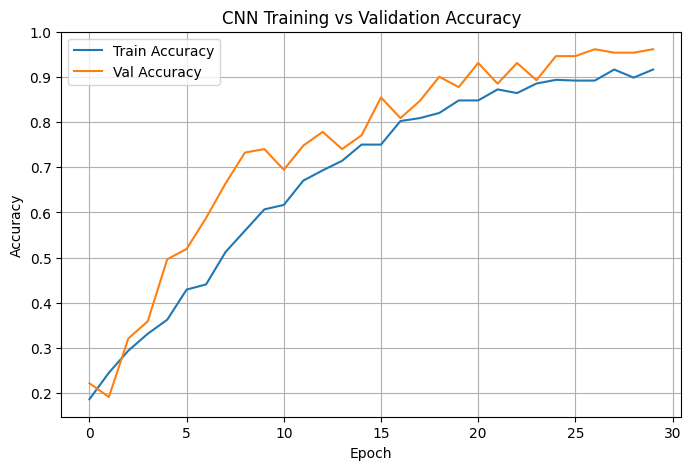

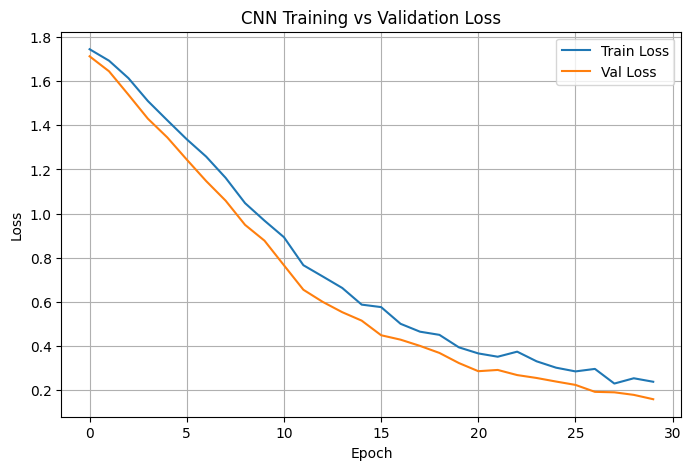

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

CNN Test Performance

Accuracy: 0.9242424242424242
precisionMacro: 0.9346414455110107
recallMacro: 0.9242424242424242
f1Macro: 0.9235456152714415
ROC-AUC (OVR): 0.9984159779614324

Classification report (CNN):

                precision    recall  f1-score   support

      No fault       1.00      0.73      0.84        22
    Root crack       1.00      1.00      1.00        22
 chipped tooth       0.91      0.91      0.91        22
  eccentricity       0.79      1.00      0.88        22
 missing tooth       0.91      0.95      0.93        22
surface defect       1.00      0.95      0.98        22

      accuracy                           0.92       132
     macro avg       0.93      0.92      0.92       132
  weighted avg       0.93      0.92      0.92       132


All Models Including CNN:

                  Accuracy  Precision    Recall   f1Macro   ROC_AUC
KNN               0.977273   0.978261  0.977273  0.977076  0.990702
SVM_RBF           0.977

In [ ]:

# Accuracy plots
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("CNN Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("CNN Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

y_proba_cnn = cnn_model.predict(xTestRaw_norm)
y_pred_cnn = np.argmax(y_proba_cnn, axis=1)

# same measurements to evaluate CNN as what we used previously
acc_cnn = accuracy_score(y_test, y_pred_cnn)
prec_cnn = precision_score(y_test, y_pred_cnn, average="macro", zero_division=0)
rec_cnn = recall_score(y_test, y_pred_cnn, average="macro", zero_division=0)
f1_cnn = f1_score(y_test, y_pred_cnn, average="macro", zero_division=0)
y_test_bin_cnn = label_binarize(y_test, classes=np.arange(num_classes))
roc_auc_cnn = roc_auc_score(y_test_bin_cnn, y_proba_cnn, multi_class="ovr")

print("\nCNN Test Performance\n")
print("Accuracy:", acc_cnn)
print("precisionMacro:", prec_cnn)
print("recallMacro:", rec_cnn)
print("f1Macro:", f1_cnn)
print("ROC-AUC (OVR):", roc_auc_cnn)
print("\nClassification report (CNN):\n")
print(classification_report(y_test, y_pred_cnn, target_names=class_names, zero_division=0))

# Add CNN evaluation row to results_df
results_df.loc["CNN_1D"] = [acc_cnn, prec_cnn, rec_cnn, f1_cnn, roc_auc_cnn]

print("\nAll Models Including CNN:\n")
print(results_df)


# 8. User Interaction and Data Outputs


Using dataLocation: /content/drive/MyDrive/DATASCI_3000_Project/Code

Files: ['no_fault.csv', 'eccentricity.csv', 'surface_fault.csv', 'tooth_chipped_fault.csv', 'missing_tooth.csv', 'root_crack.csv', 'demo_no_fault_run.csv', 'demo_eccentricity_run.csv', 'demo_missing_tooth_run.csv', 'demo_root_crack_run.csv', 'demo_surface_defect_run.csv', 'demo_chipped_tooth_run.csv', 'Old_DATASCI_Project.ipynb', 'DATASCI_Project.ipynb']

Using best classical model: KNN


INTERACTIVE DEMO
1. No fault
2. eccentricity
3. missing tooth
4. Root crack
5. surface defect
6. chipped tooth

Enter the number of the fault type you want to view: 6

Running All Use Cases for: chipped tooth

DIRECT PREDICTION
[KNN] Majority prediction: chipped tooth
Votes: {'chipped tooth': 8}
[CNN] Majority prediction: chipped tooth
Votes: {'chipped tooth': 8}


FAULT PROGRESSION (Early → Late)

Early Stage (10%)
[CNN] Majority: chipped tooth (8/8)
-> All windows correctly classified in this stage.

Mid Stage (50%)
[CNN] Majorit

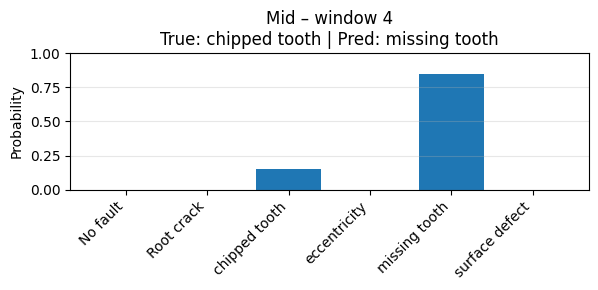


Mid – window 5
True label:      chipped tooth
Predicted label: missing tooth
       1. missing tooth   : 0.89
       2. chipped tooth   : 0.11
       3. Root crack      : 0.00
       4. No fault        : 0.00
       5. surface defect  : 0.00
       6. eccentricity    : 0.00



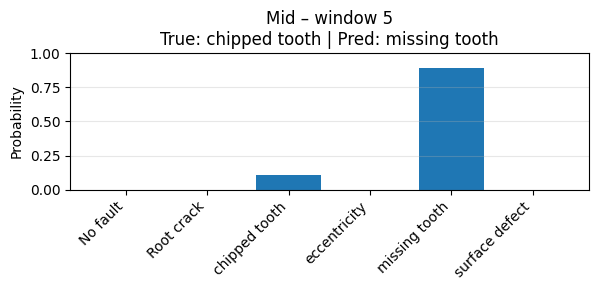


Mid – window 7
True label:      chipped tooth
Predicted label: missing tooth
       1. missing tooth   : 0.55
       2. chipped tooth   : 0.44
       3. Root crack      : 0.01
       4. No fault        : 0.00
       5. surface defect  : 0.00
       6. eccentricity    : 0.00



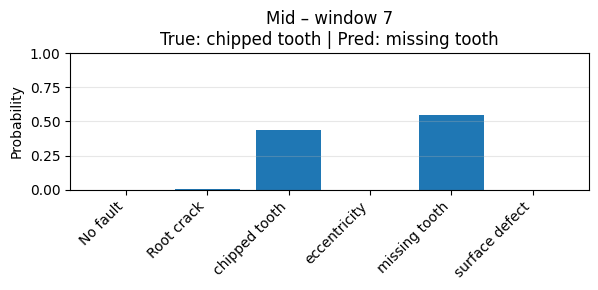


Late Stage (90%)
[CNN] Majority: chipped tooth (8/8)
-> All windows correctly classified in this stage.


SPEED ROBUSTNESS

Low Speed (50000 rows)
[CNN] Predicted: chipped tooth

High Speed (50000 rows)
[CNN] Predicted: chipped tooth


HEALTHY TO FAULTY TRANSITION (No fault to selected fault)
Healthy segment from: no_fault.csv (8192 rows)
Faulty segment from:  tooth_chipped_fault.csv (8192 rows)

Expected sequence: 8 windows of 'No fault' → 8 windows of 'chipped tooth'
Model prediction sequence by window:
['No fault', 'No fault', 'No fault', 'No fault', 'No fault', 'No fault', 'No fault', 'No fault', 'chipped tooth', 'chipped tooth', 'chipped tooth', 'chipped tooth', 'chipped tooth', 'chipped tooth', 'chipped tooth', 'chipped tooth']




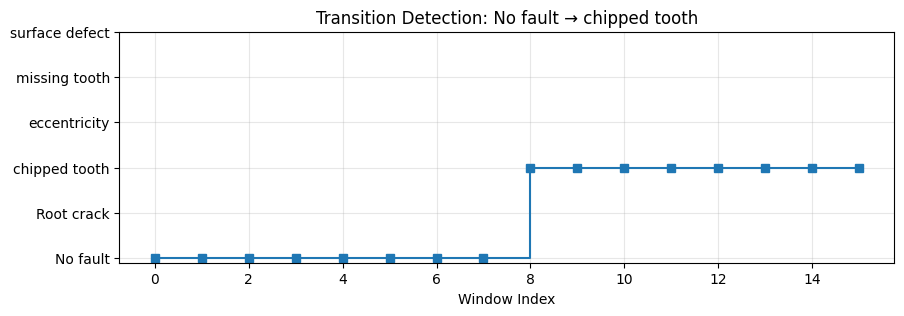



CONFUSION ANALYSIS


Window 0: 1st=chipped tooth (0.80), 2nd=No fault (0.14)
Window 1: 1st=chipped tooth (0.80), 2nd=No fault (0.12)
Window 2: 1st=chipped tooth (0.80), 2nd=No fault (0.13)
Window 3: 1st=chipped tooth (0.79), 2nd=No fault (0.15)
Window 4: 1st=chipped tooth (0.80), 2nd=No fault (0.13)
Window 5: 1st=chipped tooth (0.76), 2nd=No fault (0.19)
Window 6: 1st=chipped tooth (0.78), 2nd=No fault (0.17)
Window 7: 1st=chipped tooth (0.79), 2nd=No fault (0.11)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

print("\nUsing dataLocation:", dataLocation)
print("\nFiles:", os.listdir(dataLocation))

# Choses the best model based on accuracy, this allows for more accurate predictions
best_clf_name = max(results, key=lambda k: results[k][0])
best_clf = models[best_clf_name]
print(f"\nUsing best classical model: {best_clf_name}")

# Prepares data mapping and prepares window function for later cells.
FAULT_LABELS = [
    "No fault",
    "eccentricity",
    "missing tooth",
    "Root crack",
    "surface defect",
    "chipped tooth",
]

LABEL_TO_FILE = {
    "No fault":      "no_fault.csv",
    "eccentricity":  "eccentricity.csv",
    "missing tooth": "missing_tooth.csv",
    "Root crack":    "root_crack.csv",
    "surface defect":"surface_fault.csv",
    "chipped tooth": "tooth_chipped_fault.csv",
}

def to_plain_votes(counter_obj):
    return {str(k): int(v) for k, v in counter_obj.items()}

def get_windows_from_df(df, w_size, s_size):
    sig = df[["sensor1", "sensor2"]].values
    wins = []
    idx = 0
    while idx + w_size <= len(sig):
        wins.append(sig[idx:idx+w_size])
        idx += s_size
    return np.array(wins)

# Interactive part which allows for for testing of different fault types
print("\n")
print("INTERACTIVE DEMO")

for i, lbl in enumerate(FAULT_LABELS):
    print(f"{i+1}. {lbl}")

default_choice = 0
try:
    choice_input = input("\nEnter the number of the fault type you want to view: ")
    choice_idx = int(choice_input) - 1
    if choice_idx < 0 or choice_idx >= len(FAULT_LABELS): # make sure user choice is in range
        choice_idx = default_choice
except Exception: # use default if not valid
    choice_idx = default_choice

selected_fault = FAULT_LABELS[choice_idx]
print(f"\nRunning All Use Cases for: {selected_fault}")

src_path = os.path.join(dataLocation, LABEL_TO_FILE[selected_fault])
df_full = pd.read_csv(src_path).sort_values("time_x").reset_index(drop=True)

# Standard window extraction for all use-cases
run_len = windowSize * 8
n = len(df_full)
start_idx = np.random.randint(0, max(1, n - run_len))
end_idx = min(n, start_idx + run_len)
df_run = df_full.iloc[start_idx:end_idx].copy()

windows = get_windows_from_df(df_run, windowSize, stepSize)

# Predictions
print("\nDIRECT PREDICTION")

# Classical
X_feat = buildFeatureMatrix(windows)
X_scaled = scaler.transform(X_feat)
y_idx = best_clf.predict(X_scaled)
y_labels = LE.inverse_transform(y_idx)
votes = Counter(y_labels)

print(f"[{best_clf_name}] Majority prediction: {votes.most_common(1)[0][0]}")
print("Votes:", to_plain_votes(votes))

# CNN
X_norm = (windows - trainingMean) / trainingStandardDev
probs = cnn_model.predict(X_norm, verbose=0)
pred_idx = np.argmax(probs, axis=1)
cnn_labels = [class_names[i] for i in pred_idx]
votes_cnn = Counter(cnn_labels)

print(f"[CNN] Majority prediction: {votes_cnn.most_common(1)[0][0]}")
print("Votes:", to_plain_votes(votes_cnn))

# FAULT PROGRESSION (Early, Mid, or Late)
print("\n")
print("FAULT PROGRESSION (Early → Late)")

# Use the same file as the selected fault
faultSourceDataFrame = df_full
numberOfRows = len(faultSourceDataFrame)

# Define the three stages of fault progression and the corresponding
# relative positions (as fractions) within the full signal.
# 0.1 = early signs of the fault, 0.5 = mid-stage, 0.9 = late-stage.
faultStages = [("Early", 0.1), ("Mid", 0.5), ("Late", 0.9)]

for stageName, fraction in faultStages:

    # Compute the index that corresponds to the stage
    stageCenterIndex = int(numberOfRows * fraction)

    # Determine half the size of the block we want to extract
    # We take 8 windows and then divide by 2
    # to get a centered block around the stage
    halfBlockSize = (windowSize * 8) // 2

    # Compute the starting index
    startRowIndex = max(0, stageCenterIndex - halfBlockSize)

    # Compute the ending index
    endRowIndex = min(numberOfRows, startRowIndex + (windowSize * 8))

    # Extract current stage data
    stageDataFrame = faultSourceDataFrame.iloc[startRowIndex:endRowIndex]

    # Convert this segment into overlapping windows for CNN
    stageWindows = get_windows_from_df(stageDataFrame, windowSize, stepSize)
    if len(stageWindows) == 0: # if too small skip
        continue

    # CNN predictions for this stage
    normalizedStageWindows = (stageWindows - trainingMean) / trainingStandardDev
    stageProbabilities = cnn_model.predict(normalizedStageWindows, verbose=0)  # shape: (numWindows, numClasses)
    stagePredictedIndex = np.argmax(stageProbabilities, axis=1)
    stageLabels = np.array([class_names[i] for i in stagePredictedIndex])

    majorityLabelInfo = Counter(stageLabels).most_common(1)[0]
    print(f"\n{stageName} Stage ({int(fraction * 100)}%)")
    print(f"[CNN] Majority: {majorityLabelInfo[0]} ({majorityLabelInfo[1]}/{len(stageWindows)})")

    # Find misclassified windows (prediction different from true selected fault)
    trueLabel = selected_fault
    misclassifiedIndices = np.where(stageLabels != trueLabel)[0]

    if len(misclassifiedIndices) == 0:
        print("-> All windows correctly classified in this stage.")
        continue

    print(f"-> {len(misclassifiedIndices)} misclassified windows in this stage.")
    print("Showing probability over ALL fault types for each misclassified window:\n")

    # For each misclassified window, show class probability ranking + bar chart
    # Need to explain the probabibility for each case if not 100% for one of them
    for windowIndex in misclassifiedIndices:
        print(f"\n{stageName} – window {windowIndex}")
        print(f"True label:      {trueLabel}")
        print(f"Predicted label: {stageLabels[windowIndex]}")

        # Sort classes by probability (descending) for this window
        sortedIndices = np.argsort(-stageProbabilities[windowIndex])  # descending
        for rankIndex, classIndex in enumerate(sortedIndices):
            className = class_names[classIndex]
            probabilityValue = stageProbabilities[windowIndex, classIndex]
            print(f"       {rankIndex + 1}. {className:<15} : {probabilityValue:.2f}")
        print()

        # Bar plot of probabilities for this window across all fault types
        plt.figure(figsize=(6, 3))
        plt.bar(np.arange(len(class_names)), stageProbabilities[windowIndex])
        plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha="right")
        plt.ylim(0, 1.0)
        plt.ylabel("Probability")
        plt.title(f"{stageName} – window {windowIndex}\nTrue: {trueLabel} | Pred: {stageLabels[windowIndex]}")
        plt.grid(True, axis="y", alpha=0.3)
        plt.tight_layout()
        plt.show()



# SPEED ROBUSTNESS (if speedSet exists), shows how stable the CNN model is
# when the machine gear is at different speeds.
print("\n")
print("SPEED ROBUSTNESS")

if "speedSet" in df_full.columns:
    speeds = df_full["speedSet"].values
    q1, q3 = np.quantile(speeds, [0.25, 0.75])

    groups = {
        "Low Speed": df_full[df_full["speedSet"] <= q1],
        "High Speed": df_full[df_full["speedSet"] >= q3]
    }

    for g_name, g_df in groups.items(): # do both speed groups
        print(f"\n{g_name} ({len(g_df)} rows)")

        g_df_limited = g_df.iloc[:windowSize*8]
        g_windows = get_windows_from_df(g_df_limited, windowSize, stepSize)

        X_norm = (g_windows - trainingMean) / trainingStandardDev
        probs = cnn_model.predict(X_norm, verbose=0) # get probabilities
        pred_idx = np.argmax(probs, axis=1) #  Convert probabilities into class indices
        labels = [class_names[i] for i in pred_idx] # index to name
        maj = Counter(labels).most_common(1)[0] # final prediction is the most common class

        print(f"[CNN] Predicted: {maj[0]}")
else: # if no speed info
    print("This file has no speedSet column → skipping speed robustness.")

# True healthy to selected fault transition, sees if it can recognize when a gear develops a fault
print("\n")
print("HEALTHY TO FAULTY TRANSITION (No fault to selected fault)")

# Always use "No fault" as healthy baseline
label_h = "No fault"
label_f = selected_fault  # the fault chosen in the interactive menu

path_h = os.path.join(dataLocation, LABEL_TO_FILE[label_h])
path_f = os.path.join(dataLocation, LABEL_TO_FILE[label_f])

# Load and sort both signals by time
df_h = pd.read_csv(path_h).sort_values("time_x").reset_index(drop=True)
df_f = pd.read_csv(path_f).sort_values("time_x").reset_index(drop=True)

# Take 8 windows worth of each
rows_per_block = windowSize * 8
df_h_seg = df_h.iloc[:rows_per_block]
df_f_seg = df_f.iloc[:rows_per_block]

print(f"Healthy segment from: {LABEL_TO_FILE[label_h]} ({len(df_h_seg)} rows)")
print(f"Faulty segment from:  {LABEL_TO_FILE[label_f]} ({len(df_f_seg)} rows)")

# Concatenate: first healthy, then faulty
df_mixed = pd.concat([df_h_seg, df_f_seg], ignore_index=True)
windows = get_windows_from_df(df_mixed, windowSize, stepSize)

# CNN prediction across the transition
X_norm = (windows - trainingMean) / trainingStandardDev
probs = cnn_model.predict(X_norm, verbose=0)
pred_idx = np.argmax(probs, axis=1)
cnn_labels = [str(class_names[i]) for i in pred_idx]

print(f"\nExpected sequence: 8 windows of '{label_h}' → 8 windows of '{label_f}'")
print("Model prediction sequence by window:")
print(cnn_labels)
print("\n")

# Plot the predicted sequence to visualize
# this will visually show where it moves from healthy to faulty

label_to_idx = {name: i for i, name in enumerate(class_names)}
y_vals = [label_to_idx[lbl] for lbl in cnn_labels]

plt.figure(figsize=(10, 3))
plt.plot(y_vals, marker='s', drawstyle='steps-post')
plt.yticks(range(len(class_names)), class_names)
plt.title(f"Transition Detection: {label_h} → {label_f}")
plt.xlabel("Window Index")
plt.grid(True, alpha=0.3)
plt.show()


# CONFUSION ANALYSIS
print("\n")
print("CONFUSION ANALYSIS")
print("\n")

sub = df_full.iloc[:windowSize*8]
win = get_windows_from_df(sub, windowSize, stepSize)

X_norm = (win - trainingMean) / trainingStandardDev
probs = cnn_model.predict(X_norm, verbose=0)

sorted_idx = np.argsort(-probs, axis=1)

for i in range(len(win)):
    t1 = sorted_idx[i, 0]
    t2 = sorted_idx[i, 1]
    print(f"Window {i}: 1st={class_names[t1]} ({probs[i,t1]:.2f}), "
          f"2nd={class_names[t2]} ({probs[i,t2]:.2f})")
